In [15]:
import findspark
import pyspark
import numpy as np
import pyspark.sql.functions as sqlFunctions
import matplotlib.pyplot as plt

from operator import add
from pyspark.sql import SQLContext

%matplotlib inline

In [16]:
findspark.init()
sc = pyspark.SparkContext()
sqlContext = SQLContext(sc)

In [18]:
# Full original training set
raw_full_train = sc.textFile("dac/train.txt")

# Final test set split
raw_final_test = sc.textFile("dac/split/test.txt")  # Do not touch during training

# Training set splits
raw_test_3m = sc.textFile("dac/split/test_3m.txt")
raw_train_5m = sc.textFile("dac/split/train_5m.txt")
raw_validation_2m = sc.textFile("dac/split/train_5m.txt")

# Debug set
raw_small_train = sc.textFile("dac/small-train.txt")

In [19]:
def convert_value(index, value):
    if index < 14:
        return int(value) if value else None
    else:
        return value if value else None

def convert_line(line):
    return [convert_value(i, value) for i, value in enumerate(line.split("\t"))]

In [20]:
# Change the data types of the datasets so that the RDD's include Int's and Strings. 
full_train = raw_full_train.map(convert_line)
final_test = raw_final_test.map(convert_line)
test_3m = raw_test_3m.map(convert_line)
train_5m = raw_train_5m.map(convert_line)
validation_2m = raw_validation_2m.map(convert_line)

debug = raw_small_train.map(convert_line)

In [21]:
# Label data histogram
debug.map(lambda row: row[0]).histogram([0,1,2])

([0, 1, 2], [77337, 22663])

In [22]:
def int_column_histogram(col_num, col,numb_bins=10):
    bins, counts = col.histogram(numb_bins)
    total = sum(counts)    
    print "Column %d histogram\n\tBins=%s\n\tCounts=%s (total=%d)" % (col_num, bins, counts, total)
    # TODO: display graph of histogram
    # TODO: better buckets for histogram (smart sub-dividing)
        #sum the counts
        #max of the counts
        #if  > 25%
    return bins,counts

def int_columns_histograms(data):
    bins=[]; counts=[]
    for i, col in enumerate(column_iter(data)):
        col_num = i + 1
        if is_integer_col_num(col_num):
            bins1,counts1 = int_column_histogram(col_num, col)
            bins.append(bins1) #bin values
            counts.append(counts1) #count inside bins
            
    return bins,counts

def bin_range_labels(bins):
    #Nicely display these.
    "{:0,.3f} - {:0,.0f}"
    return ["%s---%s" % ("{:.1E}".format((bins[i])),"{:.2E}".format((bins[i+1]))) for i in range(len(bins) - 1)]




In [23]:
def get_column_num(data, col_num):
    return data.map(lambda row: row[col_num])

def column_filter_null(column):
    return column.filter(lambda row: row is not None)

def column_count(data):
    return len(data.take(1)[0])

def is_integer_col_num(col_num):
    return col_num > 1 and col_num < 15

def is_label_col_num(col_num):
    return col_num == 1

def is_categorical_col_num(col_num):
    return col_num > 15

def column_iter(data):
    for i in range(column_count(data)):
         yield get_column_num(data, i)

In [24]:
def cat_columns_histogram(data,numb_bins=10):
    hashes=[]; counts_all=[]; remainder=[];
    
    for i, col in enumerate(column_iter(data)):
        col_num = i + 1
        if is_categorical_col_num(col_num):
            key_counts = col.map(lambda key: (key, 1)).reduceByKey(add)
            sorted_counts = sorted(key_counts.collect(), key=lambda t: t[1], reverse=True)
            labels = [v[0] for v in sorted_counts]
            counts = [v[1] for v in sorted_counts]
            # TODO: graph these counts
            # TODO: truncate at something larger than 5
            hashes.append(labels[:numb_bins]) #bin values
            counts_all.append(counts[:numb_bins]) #count inside bins
            remainder.append(sum(counts[numb_bins:]))
            #print labels[:10], counts[:10], "Remaining", sum(counts[10:])
            
#            return labels[:10],counts[:10],sum(counts[10:])
    return hashes,counts_all,remainder

In [10]:
x,y,z = cat_columns_histogram(debug)
x_int, y_int =int_columns_histograms(debug)

NameError: name 'debug' is not defined

In [25]:
# This represents the Histograms for Category Features. 
# For Integer Feature we do not compute "Other Values"
# 
# x_values = 1D array of the x_values {bins OR category names}
# y_values = 1D array of the y_values {counts of uniques in bins or category name}
# isCategory = True if feature is category. 
#            = False if feature is integer.
# Z_other_values = sum of the counts of the remaining categories for category feature.
#
#
def disp_Histogram(x_values,y_values,isCategory, column_numb,z_other_value=0):
        range_x = min(len(x_values),10)
        x1 = np.arange(range_x)
        x2 = []
        
        if (isCategory):
            type_of_feature = "Category"
            x_label = "Category as a Hashed value"
            #Add Other column
            for i in x_values: 
                x2.append(str(i))
            
            x1 = np.append(x1,10)
            x2.append('Other')
            #print "HI",z_other_value
            y_values.append(z_other_value)

        else: 
            type_of_feature = "Integer"
            x_label = "Bins of Integer values"
            x2 = bin_range_labels(x_values)

        
        plt.title('%s Feature %s Histogram' % (type_of_feature,column_numb))
        plt.ylabel('Count of values')
        plt.xlabel('The %s' % x_label)
        print ("X: %s, Y: %s" % (x1,y_values))
        plt.xticks(x1, x2,rotation=45)
        print "X: %s, Y: %s" % (len(x1),len(y_values))
        plt.bar(x1, y_values,log=True)
        plt.show()

    

In [26]:
# The following Shows all the histograms for all of the features. 

def show_all_histograms(x,y,featureType,z_other_value=0):
    isCategory = True
     
    if featureType=="Integer":
        isCategory = False
       
        for i in range(len(x)):
            disp_Histogram(x[i],y[i],isCategory,i,z_other_value=0)
    else:
        isCategory = True
        for i in range(len(x)):
            #print z_other_value[i]
            disp_Histogram(x[i],y[i],isCategory,i,z_other_value[i])




In [13]:
int_columns_detail_stats(debug)

NameError: name 'int_columns_detail_stats' is not defined

In [27]:
def print_column_summary_details(col_num, kurtosis, skewness):
    print("Column #%2d: Kurtosis=%-10.3f Skewness=%-10.3f" % (col_num, kurtosis, skewness))

def int_columns_detail_stats(data):
    df = sqlContext.createDataFrame(data)
    for i, col in enumerate(column_iter(data)):
        col_num = i + 1
        if is_integer_col_num(col_num):            
            col = df["_%s" % col_num]
            k_col = sqlFunctions.kurtosis(col)
            k_result = df.select(k_col.alias("kurtosis")).collect()[0]
            s_col = sqlFunctions.skewness(col)
            s_result = df.select(s_col.alias("skewness")).collect()[0]
            print_column_summary_details(col_num, k_result.kurtosis, s_result.skewness)

In [ ]:
int_columns_detail_stats(debug)

In [ ]:
x,y,z = cat_columns_histogram(debug)

#show_all_histograms(x,y,"Category",z)
#

Column 2 histogram
	Bins=[0.0, 234.4, 468.8, 703.2, 937.6, 1172.0, 1406.4, 1640.8, 1875.2, 2109.6, 2344]
	Counts=[2608370, 218, 27, 3, 2, 1, 0, 1, 0, 1] (total=2608623)
Column 3 histogram
	Bins=[-3.0, 25764.8, 51532.6, 77300.4, 103068.2, 128836.0, 154603.8, 180371.6, 206139.4, 231907.19999999998, 257675]
	Counts=[4774841, 1, 0, 0, 0, 0, 0, 0, 0, 1] (total=4774843)
Column 4 histogram
	Bins=[0.0, 6553.5, 13107.0, 19660.5, 26214.0, 32767.5, 39321.0, 45874.5, 52428.0, 58981.5, 65535]
	Counts=[3747338, 488, 123, 242, 143, 72, 10, 3, 3, 31] (total=3748453)
Column 5 histogram
	Bins=[0, 70, 140, 210, 280, 350, 420, 490, 560, 630, 700]
	Counts=[3737174, 1777, 92, 16, 20, 10, 4, 2, 2, 4] (total=3739101)
Column 6 histogram
	Bins=[0.0, 255726.4, 511452.8, 767179.2, 1022905.6, 1278632.0, 1534358.4, 1790084.8, 2045811.2, 2301537.6, 2557264]
	Counts=[4579573, 49120, 15590, 4201, 1673, 562, 307, 40, 33, 10] (total=4651109)
Column 7 histogram
	Bins=[0.0, 26334.8, 52669.6, 79004.4, 105339.2, 131674.0, 1

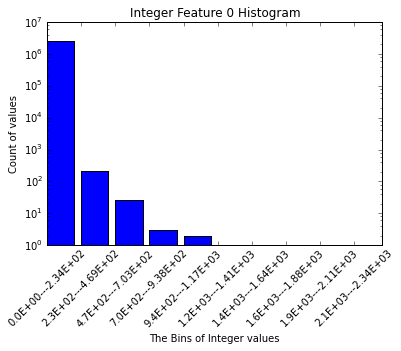

X: [0 1 2 3 4 5 6 7 8 9], Y: [4774841, 1, 0, 0, 0, 0, 0, 0, 0, 1]
X: 10, Y: 10


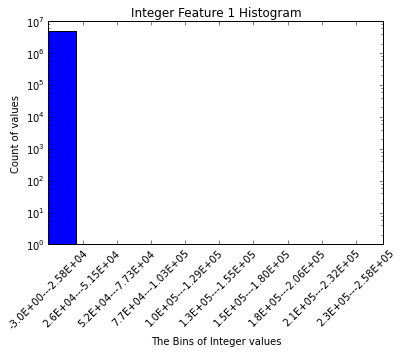

X: [0 1 2 3 4 5 6 7 8 9], Y: [3747338, 488, 123, 242, 143, 72, 10, 3, 3, 31]
X: 10, Y: 10


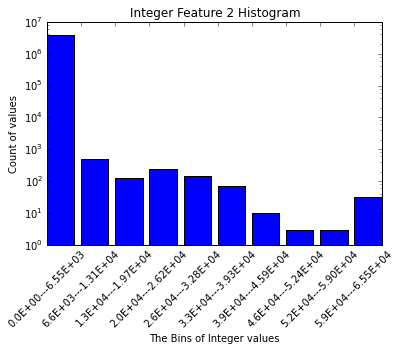

X: [0 1 2 3 4 5 6 7 8 9], Y: [3737174, 1777, 92, 16, 20, 10, 4, 2, 2, 4]
X: 10, Y: 10


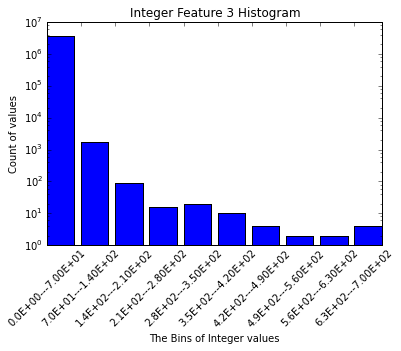

X: [0 1 2 3 4 5 6 7 8 9], Y: [4579573, 49120, 15590, 4201, 1673, 562, 307, 40, 33, 10]
X: 10, Y: 10


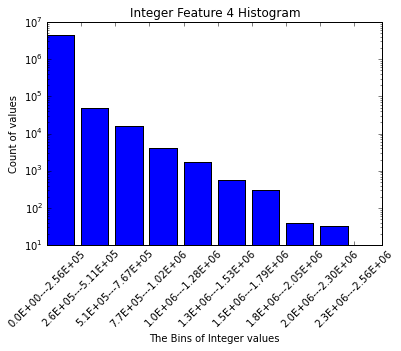

X: [0 1 2 3 4 5 6 7 8 9], Y: [3707312, 26, 3, 1, 0, 0, 0, 0, 0, 3]
X: 10, Y: 10


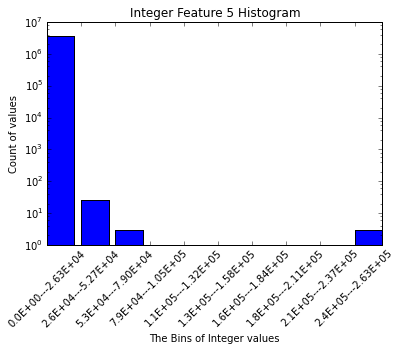

X: [0 1 2 3 4 5 6 7 8 9], Y: [4568492, 249, 16, 6, 0, 0, 0, 0, 0, 2]
X: 10, Y: 10


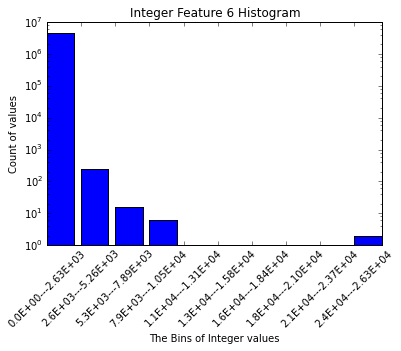

X: [0 1 2 3 4 5 6 7 8 9], Y: [4772341, 112, 21, 5, 7, 5, 5, 7, 4, 4]
X: 10, Y: 10


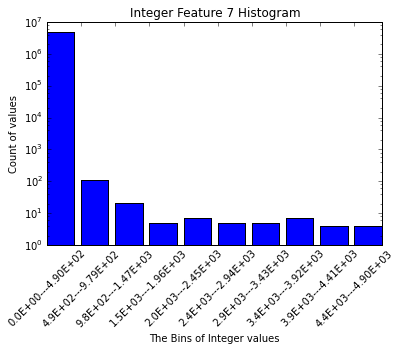

X: [0 1 2 3 4 5 6 7 8 9], Y: [4566009, 2517, 195, 35, 3, 1, 4, 0, 0, 1]
X: 10, Y: 10


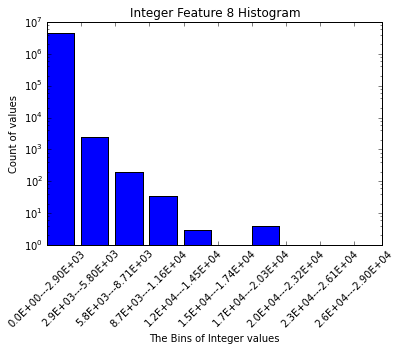

X: [0 1 2 3 4 5 6 7 8 9], Y: [1246233, 1157959, 168990, 28792, 5444, 975, 194, 29, 6, 1]
X: 10, Y: 10


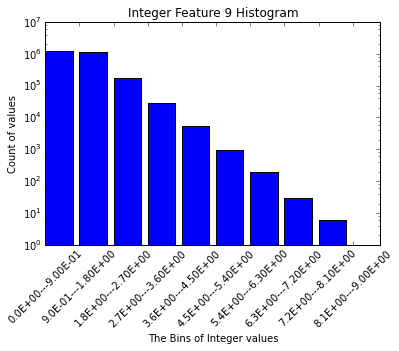

X: [0 1 2 3 4 5 6 7 8 9], Y: [4445635, 92076, 21826, 5970, 2142, 740, 258, 91, 20, 7]
X: 10, Y: 10


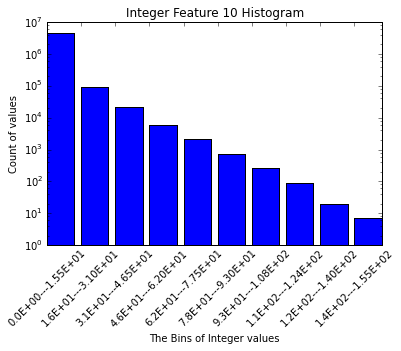

X: [0 1 2 3 4 5 6 7 8 9], Y: [1121816, 64, 4, 0, 0, 1, 1, 0, 0, 1]
X: 10, Y: 10


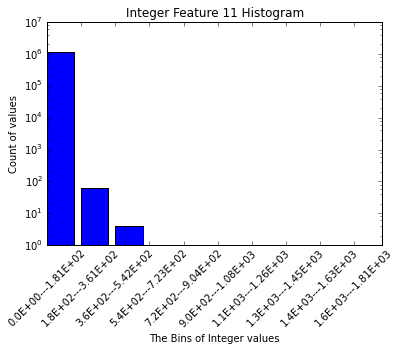

X: [0 1 2 3 4 5 6 7 8 9], Y: [3738961, 80, 16, 7, 8, 3, 7, 8, 7, 4]
X: 10, Y: 10


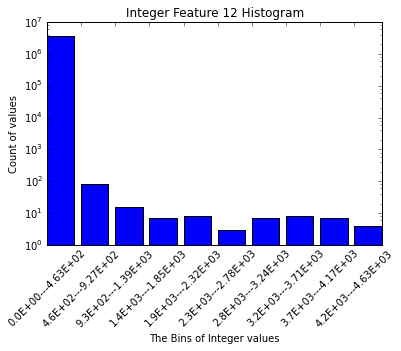

In [29]:
#This code computes the histograms based on the training sets.

#The code computes 10 bins by default.



x_int, y_int =int_columns_histograms(train_5m)
show_all_histograms(x_int,y_int,"Integer")


In [30]:
int_columns_detail_stats(train_5m)

Column # 2: Kurtosis=2467.921   Skewness=21.715    
Column # 3: Kurtosis=33043.668  Skewness=58.625    
Column # 4: Kurtosis=9174.424   Skewness=84.200    
Column # 5: Kurtosis=91.283     Skewness=3.880     
Column # 6: Kurtosis=123.590    Skewness=9.298     
Column # 7: Kurtosis=128391.376 Skewness=218.617   
Column # 8: Kurtosis=10468.553  Skewness=46.979    
Column # 9: Kurtosis=14231.391  Skewness=66.134    
Column #10: Kurtosis=259.332    Skewness=9.170     
Column #11: Kurtosis=2.366      Skewness=1.129     
Column #12: Kurtosis=58.283     Skewness=6.024     
Column #13: Kurtosis=13811.362  Skewness=59.987    
Column #14: Kurtosis=20970.745  Skewness=97.061    
